<a href="https://colab.research.google.com/github/matthewlouisbrockman/LearnGPT3/blob/main/GPT_J_6B_planning_sharable1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-J-6B Code Explanation

<a href="http://colab.research.google.com/github/kingoflolz/mesh-transformer-jax/blob/master/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uses the demo GPT-J notebook (https://colab.research.google.com/github/kingoflolz/mesh-transformer-jax/blob/master/colab_demo.ipynb)  to do math. See the git for instructions + fine tuning etc [GPT-J-6B model](https://github.com/kingoflolz/mesh-transformer-jax/#GPT-J-6B).

Stuff from the demo github

## Install Dependencies

First we download the model and install some dependencies. This step takes at least 5 minutes (possibly longer depending on server load).

!!! **Make sure you are using a TPU runtime!** !!!

In [1]:
!apt install zstd

# the "slim" version contain only bf16 weights and no optimizer parameters, which minimizes bandwidth and memory
!time wget -c https://the-eye.eu/public/AI/GPT-J-6B/step_383500_slim.tar.zstd

!time tar -I zstd -xf step_383500_slim.tar.zstd

!git clone https://github.com/kingoflolz/mesh-transformer-jax.git
!pip install -r mesh-transformer-jax/requirements.txt

# jax 0.2.12 is required due to a regression with xmap in 0.2.13
!pip install mesh-transformer-jax/ jax==0.2.12

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 278 kB of archives.
After this operation, 1,141 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 zstd amd64 1.3.3+dfsg-2ubuntu1.2 [278 kB]
Fetched 278 kB in 1s (376 kB/s)
Selecting previously unselected package zstd.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../zstd_1.3.3+dfsg-2ubuntu1.2_amd64.deb ...
Unpacking zstd (1.3.3+dfsg-2ubuntu1.2) ...
Setting up zstd (1.3.3+dfsg-2ubuntu1.2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
--2021-06-29 20:29:14--  https://the-eye.eu/public/AI/GPT-J-6B/step_383500_slim.tar.zstd
Resolving the-eye.eu (the-eye.eu)... 162.213.130.242
Connecting to the-eye.eu (the-eye.eu)|162.213.130.242|:443... connected.
HT

Processing ./mesh-transformer-jax
     |████████████████████████████████| 593kB 6.8MB/s 
  Created wheel for jax: filename=jax-0.2.12-cp37-none-any.whl size=682484 sha256=a8121f990152ccbc7e8e57b81bd1d10d1886be2353aab614e2429ca5b27a39de
  Stored in directory: /root/.cache/pip/wheels/cf/00/88/75c2043dff473f58e892c7e6adfd2c44ccefb6111fcc021e5b
  Created wheel for mesh-transformer: filename=mesh_transformer-0.0.0-cp37-none-any.whl size=21447 sha256=ed6435ce00217635d94e3351628c7fda14db336d1d643c528410ca6e4ec83730
  Stored in directory: /root/.cache/pip/wheels/de/a9/d2/2be3e25299342b60fca7965d4e416264ff8b6d8a7e8def76da
Successfully built jax mesh-transformer
  Found existing installation: jax 0.2.13
    Uninstalling jax-0.2.13:
      Successfully uninstalled jax-0.2.13


## Setup Model


In [5]:
import os
import requests 
from jax.config import config

colab_tpu_addr = os.environ['COLAB_TPU_ADDR'].split(':')[0]
url = f'http://{colab_tpu_addr}:8475/requestversion/tpu_driver0.1_dev20210607'
requests.post(url)

# The following is required to use TPU Driver as JAX's backend.
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

Sometimes the next step errors for some reason, just run it again ¯\\\_(ツ)\_/¯

In [6]:
!pip install transformers

In [8]:
import time

import jax
from jax.experimental import maps
import numpy as np
import optax
import transformers

from mesh_transformer.checkpoint import read_ckpt
from mesh_transformer.sampling import nucleaus_sample
from mesh_transformer.transformer_shard import CausalTransformer

In [9]:
params = {
  "layers": 28,
  "d_model": 4096,
  "n_heads": 16,
  "n_vocab": 50400,
  "norm": "layernorm",
  "pe": "rotary",
  "pe_rotary_dims": 64,

  "seq": 2048,
  "cores_per_replica": 8,
  "per_replica_batch": 1,
}

per_replica_batch = params["per_replica_batch"]
cores_per_replica = params["cores_per_replica"]
seq = params["seq"]


params["sampler"] = nucleaus_sample

# here we "remove" the optimizer parameters from the model (as we don't need them for inference)
params["optimizer"] = optax.scale(0)

mesh_shape = (jax.device_count() // cores_per_replica, cores_per_replica)
devices = np.array(jax.devices()).reshape(mesh_shape)

maps.thread_resources.env = maps.ResourceEnv(maps.Mesh(devices, ('dp', 'mp')))

tokenizer = transformers.GPT2TokenizerFast.from_pretrained('gpt2')

Here we create the network and load the parameters from the downloaded files. Expect this to take around 5 minutes.

In [10]:
total_batch = per_replica_batch * jax.device_count() // cores_per_replica

network = CausalTransformer(params)

network.state = read_ckpt(network.state, "step_383500/", devices.shape[1])

network.state = network.move_xmap(network.state, np.zeros(cores_per_replica))

/usr/local/lib/python3.7/dist-packages/jax/experimental/maps.py:412: UserWarning: xmap is an experimental feature and probably has bugs!
  warn("xmap is an experimental feature and probably has bugs!")


key shape (8, 2)
in shape (1, 2048)
dp 1
mp 8
read from disk/gcs in 24.7733s


## Run Model

Finally, we are ready to infer with the model! The first sample takes around a minute due to compilation, but after that it should only take about 10 seconds per sample.

Feel free to mess with the different sampling parameters (top_p and temp), as well as the length of the generations (gen_len, causes a recompile when changed).

You can also change other things like per_replica_batch in the previous cells to change how many generations are done in parallel. A larger batch has higher latency but higher throughput when measured in tokens generated/s. This is useful for doing things like best-of-n cherry picking.

*Tip for best results: Make sure your prompt does not have any trailing spaces, which tend to confuse the model due to the BPE tokenization used during training.*

In [11]:
# allow text wrapping in generated output: https://stackoverflow.com/a/61401455
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [12]:
def query(context, top_p=0, temp=0, gen_len=8):
    tokens = tokenizer.encode(context)

    provided_ctx = len(tokens)
    pad_amount = seq - provided_ctx

    padded_tokens = np.pad(tokens, ((pad_amount, 0),)).astype(np.uint32)
    batched_tokens = np.array([padded_tokens] * total_batch)
    length = np.ones(total_batch, dtype=np.uint32) * len(tokens)

    start = time.time()
    output = network.generate(batched_tokens, length, gen_len, {"top_p": np.ones(total_batch) * top_p, "temp": np.ones(total_batch) * temp})

    samples = []
    decoded_tokens = output[1][0]

    for o in decoded_tokens[:, :, 0]:
      samples.append(tokenizer.decode(o))

    print(f"completion done in {time.time() - start:06}s")
    return samples[0]

In [13]:
import random, json
import pandas as pd

In [14]:
random.seed(42)

In [15]:
fourDigitDict = []
for i in range(30):
  a = int(random.random()*10**4)
  b = int(random.random()*10**4)
  fourDigitDict.append({'first': a, "second": b, 'sum': a+b})


In [16]:
fourDigitTrainDF = pd.DataFrame(fourDigitDict)

In [17]:
fourDigitTest = []
for i in range(100):
  a = int(random.random()*10**4)
  b = int(random.random()*10**4)
  fourDigitTest.append({'first': a, "second": b, 'sum': a+b})


In [18]:
fourDigitTestDF = pd.DataFrame(fourDigitTest)

In [19]:
fourDigitTrainDF['randomlyWrong'] = fourDigitTrainDF['sum'].apply(lambda x: random.random() < .5)

In [20]:
fourDigitTrainDF['offset'] = fourDigitTrainDF['randomlyWrong'].apply(lambda x: .5-random.random() if x==True else 0)
fourDigitTrainDF['offset'] = fourDigitTrainDF['offset'] * 2000

In [21]:
fourDigitTrainDF['originalSum'] = fourDigitTrainDF['sum'] + fourDigitTrainDF['offset']

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
cd /content/drive/MyDrive/GPTJ/addingTest

/content/drive/MyDrive/GPTJ/addingTest


In [24]:
fourDigitTrainDF.to_csv('fourDigitTrainDF.csv')
fourDigitTestDF.to_csv('fourDigitTestDF.csv')

In [25]:
fourDigitTrainDF

,first,second,sum,randomlyWrong,offset,originalSum
0,6394,250,6644,False,0.000000,6644.000000
1,2750,2232,4982,False,0.000000,4982.000000
2,7364,6766,14130,True,992.908622,15122.908622
3,8921,869,9790,True,-542.238446,9247.761554
4,4219,297,4516,False,0.000000,4516.000000
5,2186,5053,7239,False,0.000000,7239.000000
6,265,1988,2253,False,0.000000,2253.000000
7,6498,5449,11947,False,0.000000,11947.000000
8,2204,5892,8096,False,0.000000,8096.000000
9,8094,64,8158,True,-274.226755,7883.773245


In [26]:
correctionPrompts = {}
purePrompts = {}

for i in range(1,30):
  correctionPrompt = ""
  purePrompt = ""
  for row in fourDigitTrainDF[:i].iterrows():
    correctionPrompt += 'Initial Answer: {} + {} = {}'.format(row[1]['first'], row[1]['second'], int(row[1]['originalSum']))
    correctionPrompt += '\n'
    interjection = 'looks correct.' if not row[1]['randomlyWrong'] else 'looks off by a bit.'
    correctionPrompt += 'Double Checking: {} {} {} + {} = {}'.format(int(row[1]['originalSum']), interjection, row[1]['first'], row[1]['second'], row[1]['sum'])
    correctionPrompt += '\n\n'

    purePrompt += '{} + {} = {}'.format(row[1]['first'], row[1]['second'], row[1]['sum']) + '\n'
  correctionPrompt += 'Initial Answer: '
  correctionPrompts[i] = correctionPrompt
  purePrompts[i] = purePrompt


In [27]:
fourDigitTestDF['formatted'] = fourDigitTestDF.apply(lambda x: "{} + {} =".format(x['first'], x['second']), axis=1)

In [28]:
import json

KeyError: ignored

In [30]:
correctionResults = {}
pureResults = {}

#for each size of example length in 1-30, run on the test set
for trainSize in range(1,30):
    if trainSize not in correctionResults:
      print(trainSize)
      correctionResults[trainSize] = []
      pureResults[trainSize] = []
      for example in fourDigitTestDF.formatted:
        correctionResults[trainSize].append(query(correctionPrompts[trainSize]+example, gen_len=50))
        pureResults[trainSize].append(query(purePrompts[trainSize]+example, gen_len=50))
    
    with open('correctionResults2.json', 'w') as fh:
      json.dump(correctionResults, fh)
    with open('pureResults2.json', 'w') as fh:
      json.dump(pureResults, fh)

Streaming output truncated to the last 5000 lines.
completion done in 1.5747995376586914s
completion done in 1.5885491371154785s
completion done in 1.588789463043213s
completion done in 1.5828261375427246s
completion done in 1.576343297958374s
completion done in 1.5754680633544922s
completion done in 1.5777757167816162s
completion done in 1.5852322578430176s
completion done in 1.5715017318725586s
completion done in 1.590331792831421s
completion done in 1.5746543407440186s
completion done in 1.573749303817749s
completion done in 1.5734896659851074s
completion done in 1.5706424713134766s
completion done in 1.5840559005737305s
completion done in 1.574319839477539s
completion done in 1.5810246467590332s
completion done in 1.5866856575012207s
completion done in 1.5848937034606934s
completion done in 1.5860884189605713s
completion done in 1.5768139362335205s
completion done in 1.5809948444366455s
completion done in 1.5841612815856934s
completion done in 1.5865709781646729s
completion done in

In [43]:
with open('pureResults2.json', 'r') as fh:
  pureResults = json.load(fh)

In [44]:
test = pd.read_csv('fourDigitTestDF.csv')

In [45]:
test.drop(test.columns[0], axis=1, inplace=True)

In [46]:
int(' 23')

23

In [47]:
def parsePureInt(x):
  base = x.split('\n')[0]
  try:
    return int(base)
  except:
    return 0

for key in pureResults.keys():
  test[key] = pureResults[key]
  test[key] = test[key].apply(lambda x: parsePureInt(x))

In [48]:
pureMape = pd.DataFrame()
for col in test.columns[3:]:
  pureMape[col] = (abs(test[col] - test['sum']))/test['sum']

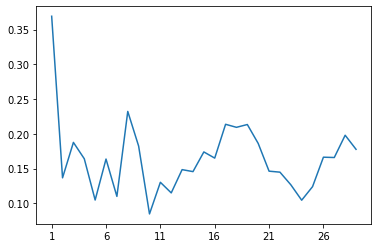

In [49]:
pureMape.mean().plot()

In [50]:
pureEM = pd.DataFrame()
for col in test.columns[3:]:
  pureEM[col] = test[col] == test['sum']

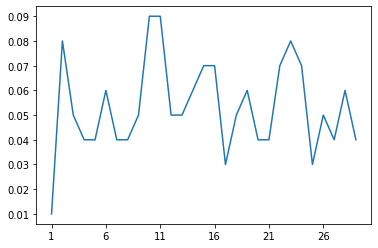

In [51]:
(pureEM.sum()/100).plot()

In [52]:
test = pd.read_csv('fourDigitTestDF.csv')
test.drop(test.columns[0], axis=1, inplace=True)

with open('correctionResults2.json', 'r') as fh:
  correctionResults = json.load(fh)

In [53]:
def parseCorrectedInt(x):
  base = x.split('\n\n')[0].split(' ')[-1]
  try:
    return int(base)
  except:
    return 0

for key in pureResults.keys():
  test[key] = correctionResults[key]
  test[key] = test[key].apply(lambda x: parseCorrectedInt(x))

In [54]:
test

,first,second,sum,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,9895,6399,16294,13184,16184,16184,13173,13184,13184,13184,16184,16184,16184,16184,16184,16184,16184,16094,16184,16184,16094,16184,16184,16184,16184,16184,16184,16184,16184,16094,16184,16184
1,5569,6846,12415,6125,12505,12505,12505,13115,12505,12505,12505,12505,12505,12505,13115,13115,12505,13115,12505,13225,12505,12505,12505,12505,12505,12505,12505,12505,12505,12305,12215,12215
2,8428,7759,16187,12187,15187,16087,15177,15177,15177,15177,15177,15177,16087,15187,15287,15177,15177,16087,16127,15187,15385,15287,14227,14077,15177,14097,15177,15177,15177,14097,15187,15177
3,2290,321,2611,2502,3221,3221,2411,2411,2411,2411,2411,2411,2411,2411,2411,2411,2411,3221,2411,2411,2411,2411,2411,2411,2311,3221,3111,3221,2411,2411,3221,3111
4,3154,2677,5831,5031,5231,5831,5231,4999,5231,5231,5231,5921,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5831,5921,5887,5921,5331,5831,5831,5831,5921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3161,7518,10679,4888,4989,10779,4688,3879,10789,10789,10779,10879,10789,10789,10789,10789,10789,10779,10779,10789,10879,11509,10779,10879,10789,10789,10879,10879,10779,10779,10879,10789
96,725,4582,5307,7697,11007,11007,7297,8107,11007,11007,11007,11007,11007,11007,11007,11007,5807,11007,11007,11107,11007,11007,11807,11007,11007,10583,11007,11007,11007,11007,11007,11007
97,9984,9960,19944,19924,19944,19924,19924,19924,19924,19924,19924,19924,19924,19944,19924,19944,19944,19944,19924,19924,19924,19924,19924,19924,19924,19924,19924,19924,19924,19924,19924,19924
98,732,2131,2863,3253,1453,1343,3153,3153,9353,953,953,953,953,953,3163,2153,2153,2453,3453,3153,3153,3163,3163,953,953,1353,3163,3163,953,3163,3163,3163


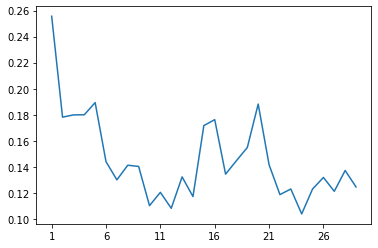

In [55]:
correctedMape = pd.DataFrame()
for col in test.columns[3:]:
  correctedMape[col] = (abs(test[col] - test['sum']))/test['sum']
correctedMape.mean().plot()

In [56]:
correctedeEM = pd.DataFrame()
for col in test.columns[3:]:
  correctedeEM[col] = test[col] == test['sum']

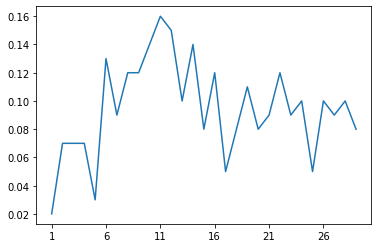

In [57]:
(correctedeEM.sum()/100).plot()

In [58]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Mean Error')

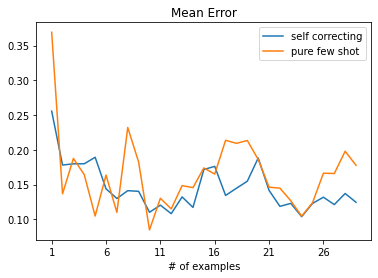

In [59]:
ax = correctedMape.mean().plot(label='self correcting')
pureMape.mean().plot(ax=ax, label='pure few shot')
ax.legend()
ax.set_xlabel('# of examples')
ax.set_title('Mean Error')

Text(0.5, 1.0, 'Exact Match')

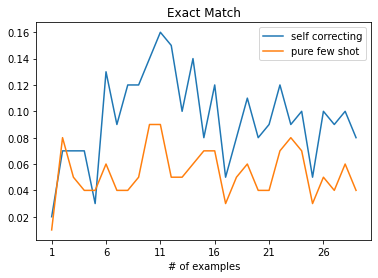

In [60]:
ax = (correctedeEM.sum()/100).plot(label='self correcting')
(pureEM.sum()/100).plot(ax=ax, label='pure few shot')
ax.legend()
ax.set_xlabel('# of examples')
ax.set_title('Exact Match')

Text(0.5, 0.98, '4 Digit Arithmetic on 100 Tests')

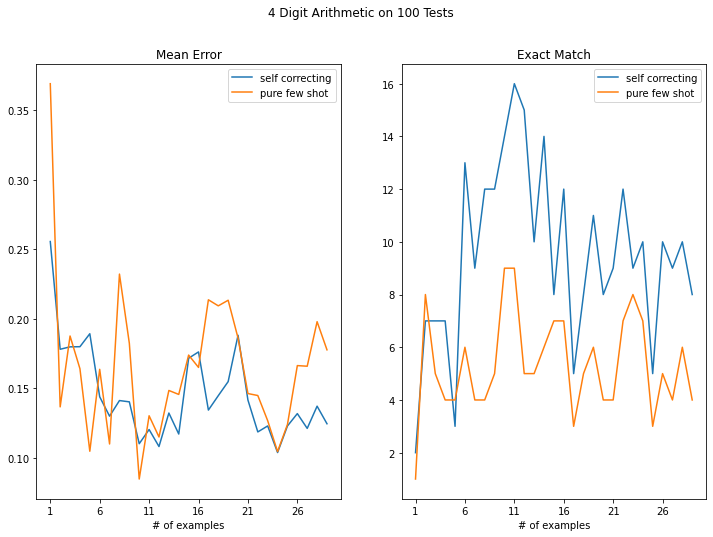

In [61]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,8), facecolor='white')
correctedMape.mean().plot(label='self correcting', ax=axs[0])
pureMape.mean().plot(ax=axs[0], label='pure few shot')
axs[0].legend()
axs[0].set_xlabel('# of examples')
axs[0].set_title('Mean Error')

(correctedeEM.sum()).plot(label='self correcting', ax=axs[1])
(pureEM.sum()).plot(ax=axs[1], label='pure few shot')
axs[1].legend()
axs[1].set_xlabel('# of examples')
axs[1].set_title('Exact Match')

fig.suptitle('4 Digit Arithmetic on 100 Tests')